# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
from sqlalchemy import create_engine

# загружаем переменные окружения из .env
load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

print("Переменные окружения загружены.")


Переменные окружения загружены.


In [2]:

# Строка подключения к PostgreSQL на основе .env
connection_string = (
    f"postgresql://{DB_USER}:{DB_PASS}"
    f"@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    f"?sslmode=require"
)

engine = create_engine(connection_string)
print("Подключение к базе успешно создано.")


Подключение к базе успешно создано.


In [3]:
query = """
WITH set_config_precode AS (
    SELECT set_config('synchronize_seqscans', 'off', true)
),

orders_extended AS (
    SELECT
        p.user_id,
        p.device_type_canonical,
        p.order_id,
        p.created_dt_msk AS order_dt,
        p.created_ts_msk AS order_ts,
        p.currency_code,
        p.revenue,
        p.tickets_count,
        p.event_id,
        p.service_name,
        e.event_type_main,
        c.city_name,
        r.region_name,
        LAG(p.created_dt_msk::date) OVER (
            PARTITION BY p.user_id
            ORDER BY p.created_dt_msk
        ) AS prev_order_dt
    FROM afisha.purchases p
    JOIN afisha.events e
        ON p.event_id = e.event_id
    JOIN afisha.city c
        ON e.city_id = c.city_id
    JOIN afisha.regions r
        ON c.region_id = r.region_id
    WHERE
        p.device_type_canonical IN ('mobile', 'desktop')
        AND e.event_type_main <> 'фильм'
)

SELECT
    user_id,
    device_type_canonical,
    order_id,
    order_dt,
    order_ts,
    currency_code,
    revenue,
    tickets_count,
    (order_dt::date - prev_order_dt) AS days_since_prev,
    event_id,
    service_name,
    event_type_main,
    region_name,
    city_name
FROM orders_extended
ORDER BY user_id;
"""


In [4]:
df = pd.read_sql(query, con=engine)

# на всякий случай посмотрим, что всё ок:
display(df.shape)
df.head()


(290611, 14)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [5]:
df.info()
df.describe(include='all')
df.isna().sum()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


В результате выгрузки данных из базы data-analyst-afisha получено 290 611 строк и 14 колонок. Структура датафрейма соответствует требованиям задачи. Все ключевые признаки, включая информацию о заказах, пользователях, типах мероприятий и географии, успешно загружены.

Типы данных в целом корректны: поля order_dt и order_ts уже представлены в формате datetime64, показатели выручки и количества билетов имеют числовой тип. Идентификаторы пользователей и справочные поля хранятся в виде строковых значений, что также корректно.

Пропуски наблюдаются только в колонке days_since_prev (около 7.6% строк). Это ожидаемая ситуация для пользователей с единственной покупкой, поэтому пропуски не требуют удаления.

На этапе предобработки планируется:

сохранить идентификаторы в строковом формате;

при необходимости привести категориальные признаки (device_type_canonical, service_name, event_type_main, region_name, city_name) к типу category;

проверить корректность значений days_since_prev и отсутствие отрицательных интервалов.

В целом данные загружены корректно, структура датафрейма готова к дальнейшему анализу.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [6]:
#загружаем курс рубль-тенге
import pandas as pd

url_tenge = 'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
tenge_rate_df = pd.read_csv(url_tenge)

tenge_rate_df.head()
tenge_rate_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [7]:
#готовим датафрейм с курсом
import pandas as pd
import numpy as np

url_tenge = 'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
tenge_rate_df = pd.read_csv(url_tenge)

# переименуем колонку даты и приведём её к типу date
tenge_rate_df.rename(columns={'data': 'order_date'}, inplace=True)
tenge_rate_df['order_date'] = pd.to_datetime(tenge_rate_df['order_date']).dt.date

tenge_rate_df.head()


,order_date,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
df['order_date'] = df['order_dt'].dt.date

In [9]:
#мерджим курс в основной датафрейм
df = df.merge(
    tenge_rate_df[['order_date', 'nominal', 'curs', 'cdx']],
    on='order_date',
    how='left'
)

In [10]:
# на всякий случай приведём код валюты к верхнему регистру
df['currency_code'] = df['currency_code'].str.upper()

# базово: для рублёвых заказов выручка уже в рублях
df['revenue_rub'] = df['revenue']

# маска для заказов в тенге
mask_kzt = df['currency_code'] == 'KZT'

df.loc[mask_kzt, 'revenue_rub'] = (
    df.loc[mask_kzt, 'revenue'] * df.loc[mask_kzt, 'curs'] / df.loc[mask_kzt, 'nominal']
)

In [11]:
df[['order_date', 'currency_code', 'revenue', 'curs', 'nominal', 'revenue_rub']].head(10)

,order_date,currency_code,revenue,curs,nominal,revenue_rub
0,2024-08-20,RUB,1521.94,18.6972,100,1521.94
1,2024-07-23,RUB,289.45,18.3419,100,289.45
2,2024-10-06,RUB,1258.57,19.6475,100,1258.57
3,2024-07-13,RUB,8.49,18.5010,100,8.49
4,2024-10-04,RUB,1390.41,19.6648,100,1390.41
5,2024-10-23,RUB,902.74,20.0531,100,902.74
6,2024-08-15,RUB,917.83,18.7730,100,917.83
7,2024-09-29,RUB,47.78,19.3741,100,47.78
8,2024-10-15,RUB,74.84,19.7185,100,74.84
9,2024-06-20,RUB,1421.91,18.0419,100,1421.91


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [12]:
#проверим данные на пропущенные значения
df.isna().sum()
df.isna().mean().round(4)

user_id                  0.0000
device_type_canonical    0.0000
order_id                 0.0000
order_dt                 0.0000
order_ts                 0.0000
currency_code            0.0000
revenue                  0.0000
tickets_count            0.0000
days_since_prev          0.0755
event_id                 0.0000
service_name             0.0000
event_type_main          0.0000
region_name              0.0000
city_name                0.0000
order_date               0.0000
nominal                  0.0000
curs                     0.0000
cdx                      0.0000
revenue_rub              0.0000
dtype: float64

In [13]:
df[df['revenue_rub'].isna()].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,order_date,nominal,curs,cdx,revenue_rub


In [14]:
#немного оптимизируем по памяти

# идентификаторы — строки
df['user_id'] = df['user_id'].astype(str)
df['order_id'] = df['order_id'].astype(str)
df['event_id'] = df['event_id'].astype(str)

# числовые — компактнее
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')
df['revenue'] = pd.to_numeric(df['revenue'], downcast='float')
df['revenue_rub'] = pd.to_numeric(df['revenue_rub'], downcast='float')
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'], downcast='float')


In [15]:
#проверка значений в ключевых категориальных столбцах
cat_cols = [
    'device_type_canonical',
    'currency_code',
    'service_name',
    'event_type_main',
    'region_name',
    'city_name'
]

for col in cat_cols:
    print(f'\n{col}')
    print(df[col].value_counts(dropna=False).head(15))



device_type_canonical
device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

currency_code
currency_code
RUB    285542
KZT      5069
Name: count, dtype: int64

service_name
service_name
Билеты без проблем        63519
Лови билет!               41124
Билеты в руки             40343
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17774
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Name: count, dtype: int64

event_type_main
event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: count, dtype: int64

region_name
region_name
Каменевский регион         91058
Североярская область       

In [16]:
#Проверка распределения численных данных + выбросы
df[['revenue_rub', 'tickets_count', 'days_since_prev']].describe(
    percentiles=[0.5, 0.9, 0.95, 0.99]
)

,revenue_rub,tickets_count,days_since_prev
count,290611.000000,290611.000000,268678.000000
mean,555.571987,2.754311,3.222381
std,875.498172,1.170620,11.343196
min,-90.760000,1.000000,0.000000
50%,351.140000,3.000000,0.000000
90%,1294.770000,4.000000,7.000000
95%,1630.650000,5.000000,18.000000
99%,2628.421739,6.000000,63.000000
max,81174.540000,57.000000,148.000000


Text(0.5, 1.0, 'Распределение количества билетов в заказе')

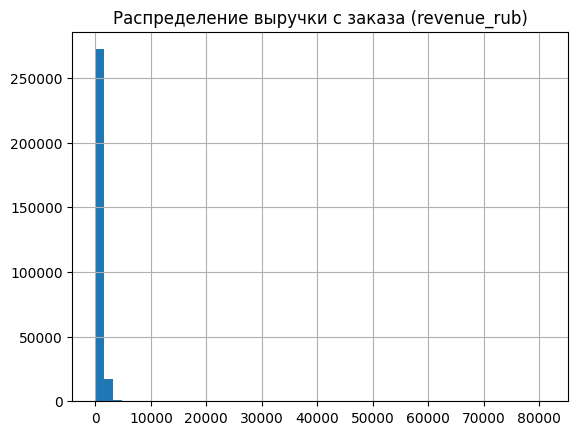

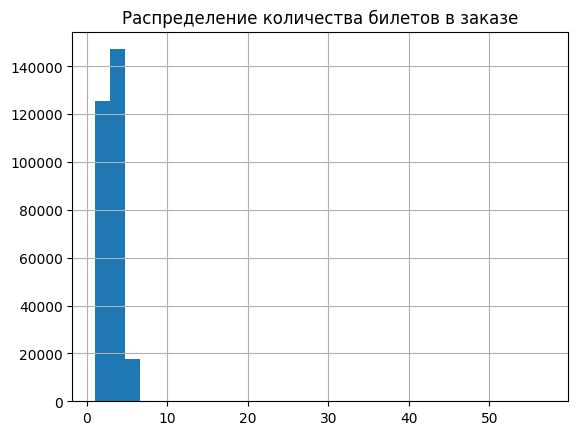

In [17]:
import matplotlib.pyplot as plt

plt.figure()
df['revenue_rub'].hist(bins=50)
plt.title('Распределение выручки с заказа (revenue_rub)')

plt.figure()
df['tickets_count'].hist(bins=30)
plt.title('Распределение количества билетов в заказе')


In [18]:
#фильтрация выбросов по 99-му перцентилю для revenue_rub
p99_revenue = df['revenue_rub'].quantile(0.99)
p99_revenue

np.float64(2628.4217390400004)

In [19]:
df_before = df.copy()

df = df[df['revenue_rub'] <= p99_revenue]

removed_rows = len(df_before) - len(df)
removed_share = removed_rows / len(df_before)

print('Удалено строк:', removed_rows)
print('Доля удалённых строк:', round(removed_share * 100, 2), '%')


Удалено строк: 2825
Доля удалённых строк: 0.97 %


***Промежуточный вывод по предобработке данных***

**Приведение выручки к рублям**

Для заказов в тенге был загружен датасет с курсами валют.
Для корректного объединения с ним создан новый столбец order_date (дата без времени).
После объединения в таблицу добавились технические столбцы nominal, curs, cdx, использованные для расчёта нового показателя revenue_rub, отражающего выручку в российских рублях.
Для заказов в рублях revenue_rub совпадает с исходной выручкой.

**Пропуски**

Пропуски обнаружены только в days_since_prev, что ожидаемо для пользователей с единственной покупкой. В остальных столбцах пропусков нет.

**Типы данных**

Идентификаторы приведены к строковому типу, даты — к datetime64, числовые значения оптимизированы. Новый столбец order_date используется только для соединения с курсами валют.

**Категориальные признаки**

Все категориальные значения корректны; искусственно закодированных пропусков не выявлено. Нормализация не потребовалась.

**Числовые данные и выбросы**

Обнаружены отрицательные и аномально большие значения revenue_rub.
Отрицательные значения удалены. Далее по условию задания были удалены выбросы выше 99-го перцентиля (2628.42 руб.).

Удалено 2825 строк (0.97% данных), что не влияет на репрезентативность выборки.

**Итог**


Датасет успешно очищен, выручка приведена к единой валюте, а новые столбцы (order_date, revenue_rub) корректно сформированы. Данные полностью готовы к дальнейшему анализу пользовательского поведения и расчёту продуктовых метрик.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [20]:
#сортируем данные по времени соверщения заказа
df = df.sort_values(by=['user_id', 'order_ts'])

Для каждого user_id вычисляем:

first_order_dt — дата первого заказа

last_order_dt — дата последнего заказа

first_device — устройство первого заказа

first_region — регион первого заказа

first_service — билетный партнёр первого заказа

first_event_type — жанр первого посещённого мероприятия

total_orders — количество заказов

avg_revenue_rub — средняя выручка с заказа в рублях

avg_tickets — среднее число билетов

avg_days_between_orders — среднее время между заказами

In [21]:
# 1. Дата первого и последнего заказа
user_profile = df.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'),
    last_order_dt=('order_dt', 'max'),
)

# 2. Данные из первого заказа
first_orders = df.groupby('user_id').first()

user_profile['first_device'] = first_orders['device_type_canonical']
user_profile['first_region'] = first_orders['region_name']
user_profile['first_service'] = first_orders['service_name']
user_profile['first_event_type'] = first_orders['event_type_main']

# 3. Количество заказов и средние метрики
user_profile['total_orders'] = df.groupby('user_id')['order_id'].count()
user_profile['avg_revenue_rub'] = df.groupby('user_id')['revenue_rub'].mean()
user_profile['avg_tickets'] = df.groupby('user_id')['tickets_count'].mean()

# 4. Среднее время между заказами
user_profile['avg_days_between_orders'] = (
    df.groupby('user_id')['days_since_prev'].mean()
)

# 5. Бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

user_profile.head()

,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [22]:
#базовые метрики по пользователям
# 1. Общее число пользователей
total_users = user_profile.shape[0]

# 2. Средняя выручка с заказа (берём среднюю по пользователям)
avg_revenue_per_order = user_profile['avg_revenue_rub'].mean()

# 3. Доля пользователей с ≥2 заказами
share_two_plus = user_profile['is_two'].mean()

# 4. Доля пользователей с ≥5 заказами
share_five_plus = user_profile['is_five'].mean()

print("Общее число пользователей:", total_users)
print("Средняя выручка с одного заказа:", avg_revenue_per_order)
print("Доля пользователей с ≥2 заказами:", share_two_plus)
print("Доля пользователей с ≥5 заказами:", share_five_plus)


Общее число пользователей: 21854
Средняя выручка с одного заказа: 544.398050897431
Доля пользователей с ≥2 заказами: 0.6170952686007138
Доля пользователей с ≥5 заказами: 0.2900613160062231


**Статистика по ключевым пользовательским характеристикам**

In [23]:
#по общему числу заказов
user_profile['total_orders'].describe(percentiles=[0.5, 0.9, 0.95, 0.99])

count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
50%          2.000000
90%         15.000000
95%         31.350000
99%        152.000000
max      10181.000000
Name: total_orders, dtype: float64

**Аномалии:**

 медиана: 2,  90-й перцентиль: 15,  95-й перцентиль: 31, 99-й перцентиль: 152,  максимум: 10 181

Тут явно видно: «нормальные» пользователи — до нескольких десятков заказов, а значения в тысячи заказов — аномалия (корпоративы/партнёры/ошибки).

Вывод: нужно отфильтровать по 99-му перцентилю (152 заказа).

In [24]:
#по среднему числу билетов
user_profile['avg_tickets'].describe(percentiles=[0.5, 0.9, 0.95, 0.99])

count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
50%          2.750000
90%          4.000000
95%          4.000000
99%          5.000000
max         11.000000
Name: avg_tickets, dtype: float64

**Аномалии:** 

медиана: 2.75, 
99-й перцентиль: 5, 
максимум: 11

11 билетов — много, но реалистично для группы людей.

Вывод: аномалий нет, не фильтруем.

In [25]:
#по среднему количеству дней между покупками
user_profile['avg_days_between_orders'].describe(percentiles=[0.5, 0.9, 0.95, 0.99])

count    13513.000000
mean        15.851275
std         22.306587
min          0.000000
50%          8.000000
90%         41.500000
95%         61.500000
99%        112.000000
max        148.000000
Name: avg_days_between_orders, dtype: float64

**Аномалии**

медиана: 8 дней, 
99-й перцентиль: 112, 
максимум: 148

Это просто редкие, нечасто возвращающиеся пользователи.

Вывод: аномалий нет, не фильтруем.

**Вывод по аномалиям**

Принятое решение по обработке аномалий

Для уменьшения влияния экстремальных значений по числу заказов было принято решение удалить пользователей, чьё значение total_orders превышает 99-й перцентиль (152 заказа). Это позволит исключить редко встречающиеся аномальные наблюдения, не уменьшая существенно объём выборки.

In [26]:
#фильтруем по 99-му перцентилю total_orders

# 99-й перцентиль по общему числу заказов
p99_orders = user_profile['total_orders'].quantile(0.99)
print('99-й перцентиль по числу заказов:', p99_orders)

# фильтрация аномальных пользователей
user_profile_filtered = user_profile[user_profile['total_orders'] <= p99_orders]

removed_users = len(user_profile) - len(user_profile_filtered)
removed_share = removed_users / len(user_profile)

print('Удалено пользователей:', removed_users)
print('Доля удалённых пользователей:', round(removed_share * 100, 2), '%')

# пересчёт статистик по обновлённому датасету
user_profile_filtered[['total_orders', 'avg_tickets', 'avg_days_between_orders']].describe(
    percentiles=[0.5, 0.9, 0.95, 0.99]
)


99-й перцентиль по числу заказов: 152.0
Удалено пользователей: 216
Доля удалённых пользователей: 0.99 %


,total_orders,avg_tickets,avg_days_between_orders
count,21638.000000,21638.000000,13297.000000
mean,6.501294,2.743319,16.101315
std,14.324031,0.917486,22.399916
min,1.000000,1.000000,0.000000
50%,2.000000,2.750000,8.352942
90%,14.000000,4.000000,42.000000
95%,26.000000,4.000000,62.000000
99%,80.000000,5.000000,113.000000
max,152.000000,11.000000,148.000000


**Вывод по фильтрации**

Удалено пользователей: 216

Доля удалённых пользователей: 0.99%

Таким образом, после очистки в выборке осталось 21 638 пользователей, что по-прежнему обеспечивает достаточную репрезентативность данных.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [27]:
#подсчитываем распределения
def segment_stats(df, column):
    seg = df[column].value_counts().reset_index()
    seg.columns = [column, "users"]
    seg["share"] = seg["users"] / seg["users"].sum()
    return seg

In [28]:
#распределения по каждому признаку
event_type_seg = segment_stats(user_profile_filtered, "first_event_type")
device_seg = segment_stats(user_profile_filtered, "first_device")
region_seg = segment_stats(user_profile_filtered, "first_region")
service_seg = segment_stats(user_profile_filtered, "first_service")

event_type_seg, device_seg, region_seg, service_seg

(  first_event_type  users     share
 0         концерты   9560  0.441815
 1           другое   5426  0.250763
 2            театр   4239  0.195905
 3          стендап   1110  0.051299
 4            спорт    794  0.036695
 5         выставки    414  0.019133
 6             ёлки     95  0.004390,
   first_device  users     share
 0       mobile  17924  0.828358
 1      desktop   3714  0.171642,
                 first_region  users     share
 0         Каменевский регион   7085  0.327433
 1       Североярская область   3767  0.174092
 2        Широковская область   1224  0.056567
 3           Озернинский край    675  0.031195
 4       Малиновоярский округ    525  0.024263
 ..                       ...    ...       ...
 76         Светолесский край      2  0.000092
 77       Тихогорская область      2  0.000092
 78  Сосноводолинская область      1  0.000046
 79        Яснопольский округ      1  0.000046
 80         Верхозёрский край      1  0.000046
 
 [81 rows x 3 columns],
             

**Вывод**

In [29]:
#выведем долю в процентах для удобства
event_type_seg['share_pct'] = (event_type_seg['share'] * 100).round(1)

print("Распределение по первому жанру:")
display(event_type_seg[['first_event_type', 'users', 'share_pct']])


Распределение по первому жанру:


,first_event_type,users,share_pct
0,концерты,9560,44.2
1,другое,5426,25.1
2,театр,4239,19.6
3,стендап,1110,5.1
4,спорт,794,3.7
5,выставки,414,1.9
6,ёлки,95,0.4


Концерты — ключевая точка входа (44% всех пользователей).
Затем идут категории «Другое» и театр.
Остальные жанры дают значительно меньший поток новых пользователей.

In [30]:
#переводим в проценты
device_seg['share_pct'] = (device_seg['share'] * 100).round(1)

print("Распределение по первому устройству:")
display(device_seg[['first_device', 'users', 'share_pct']])


Распределение по первому устройству:


,first_device,users,share_pct
0,mobile,17924,82.8
1,desktop,3714,17.2


Распределение резко смещено в сторону мобильных устройств.
Почти 83% пользователей впервые приходят через смартфон, что делает мобильный канал главным воронкой привлечения.

In [31]:
#переводим в проценты
region_seg['share_pct'] = (region_seg['share'] * 100).round(2)

print("Распределение по региону первого заказа:")
display(region_seg[['first_region', 'users', 'share_pct']])



Распределение по региону первого заказа:


,first_region,users,share_pct
0,Каменевский регион,7085,32.74
1,Североярская область,3767,17.41
2,Широковская область,1224,5.66
3,Озернинский край,675,3.12
4,Малиновоярский округ,525,2.43
...,...,...,...
76,Светолесский край,2,0.01
77,Тихогорская область,2,0.01
78,Сосноводолинская область,1,0.00
79,Яснопольский округ,1,0.00


Для регионов лучше округлять до двух знаков, потому что в длинном хвосте доли очень маленькие (0.0001 → 0.01%).

In [32]:
service_seg['share_pct'] = (service_seg['share'] * 100).round(2)

print("Распределение по первому билетному партнёру:")
display(service_seg[['first_service', 'users', 'share_pct']])

Распределение по первому билетному партнёру:


,first_service,users,share_pct
0,Билеты без проблем,5186,23.97
1,Мой билет,2969,13.72
2,Лови билет!,2809,12.98
3,Билеты в руки,2559,11.83
4,Облачко,2177,10.06
5,Весь в билетах,1285,5.94
6,Лучшие билеты,1184,5.47
7,Прачечная,583,2.69
8,Край билетов,454,2.10
9,Дом культуры,356,1.65


Пять крупнейших билетных операторов приводят более 70% всех новых пользователей.
Особенно выделяется «Билеты без проблем» — почти четверть всех первых заказов.

Длинный хвост партнёров существует, но его вклад минимальный.

**Общий вывод:**
    
Распределение пользователей по признакам первого заказа неравномерное, и у платформы есть ярко выраженные точки входа:

жанры: доминируют концерты (44%)

устройства: мобильные телефоны (83%)

регионы: лидирует Каменевский регион (33%)

партнёры: несколько крупнейших операторов обеспечивают основной поток клиентов.

Эти сегменты являются ключевыми для анализа возвратности и построения моделей прогнозирования.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [33]:
#напишем функцию для анализа возвратов по сегменту
def return_rate_by_segment(df, column):
    seg = (
        df.groupby(column)
        .agg(
            users=('is_two', 'count'),
            returning=('is_two', 'mean')  # доля пользователей с >= 2 заказами
        )
        .sort_values('users', ascending=False)
    )
    seg['returning_pct'] = (seg['returning'] * 100).round(1)
    return seg

Делаем анализ по каждому признаку первого заказа:

In [34]:
#по типу первого мероприятия
event_return = return_rate_by_segment(user_profile_filtered, "first_event_type")
event_return

,users,returning,returning_pct
first_event_type,,,
концерты,9560,0.618305,61.8
другое,5426,0.596203,59.6
театр,4239,0.633876,63.4
стендап,1110,0.609009,60.9
спорт,794,0.557935,55.8
выставки,414,0.640097,64.0
ёлки,95,0.557895,55.8


In [35]:
#по типу устройства
device_return = return_rate_by_segment(user_profile_filtered, "first_device")
device_return

,users,returning,returning_pct
first_device,,,
mobile,17924,0.608123,60.8
desktop,3714,0.638126,63.8


In [36]:
#по региону первого заказа(топ 10)
region_return = return_rate_by_segment(user_profile_filtered, "first_region")
region_return_top10 = region_return.head(10)
region_return_top10

,users,returning,returning_pct
first_region,,,
Каменевский регион,7085,0.623994,62.4
Североярская область,3767,0.638174,63.8
Широковская область,1224,0.645425,64.5
Озернинский край,675,0.552593,55.3
Малиновоярский округ,525,0.560000,56.0
Шанырский регион,500,0.672000,67.2
Травяная область,488,0.614754,61.5
Светополянский округ,457,0.656455,65.6
Речиновская область,440,0.634091,63.4


In [37]:
#по первому билетному оператору(топ 10)
service_return = return_rate_by_segment(user_profile_filtered, "first_service")
service_return_top10 = service_return.head(10)
service_return_top10

,users,returning,returning_pct
first_service,,,
Билеты без проблем,5186,0.604126,60.4
Мой билет,2969,0.608622,60.9
Лови билет!,2809,0.609114,60.9
Билеты в руки,2559,0.627198,62.7
Облачко,2177,0.612770,61.3
Весь в билетах,1285,0.628794,62.9
Лучшие билеты,1184,0.612331,61.2
Прачечная,583,0.626072,62.6
Край билетов,454,0.651982,65.2


Визуализируем по регионам и партнерам (топ 10)

In [38]:
def plot_return_rate(df, title):
    df_sorted = df.sort_values('returning_pct') 
    plt.figure(figsize=(10, 5))
    plt.bar(df_sorted.index, df_sorted['returning_pct'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Доля возвратов (%)")
    plt.title(title)
    plt.show()

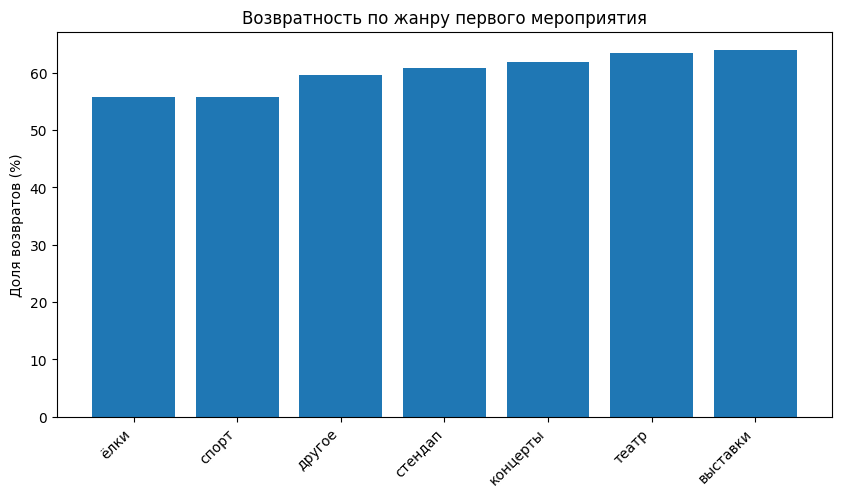

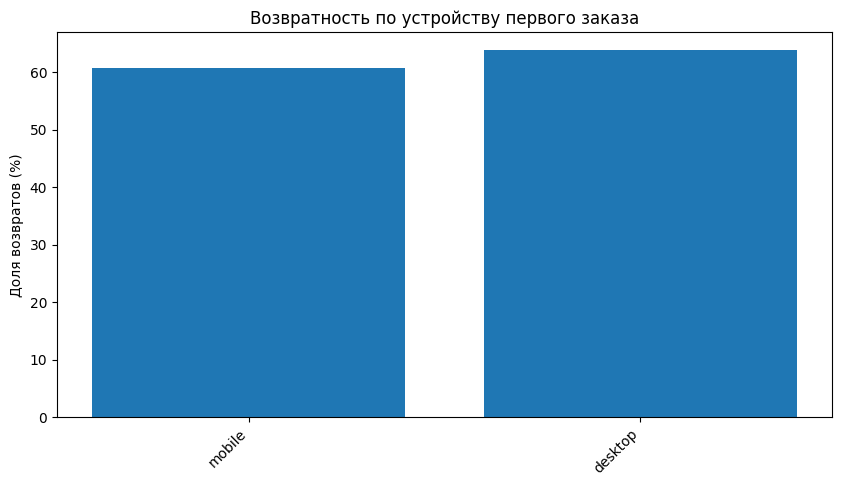

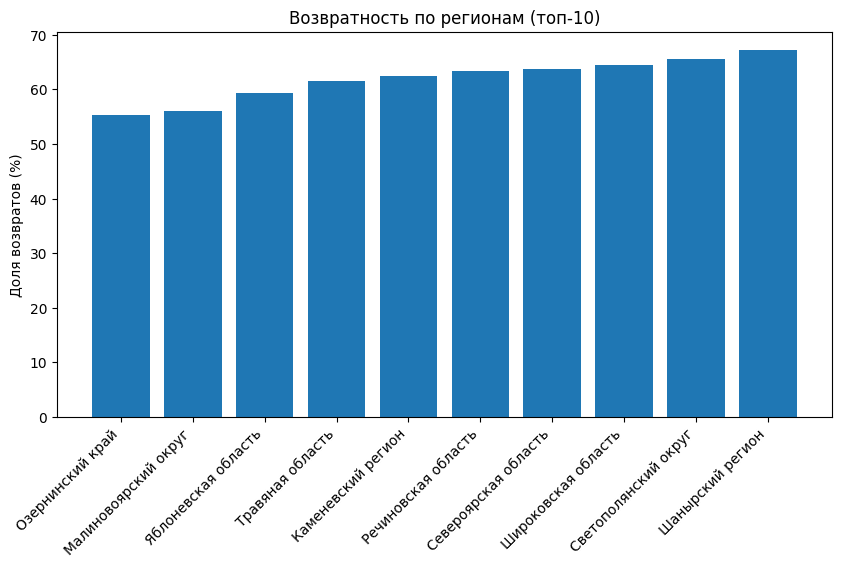

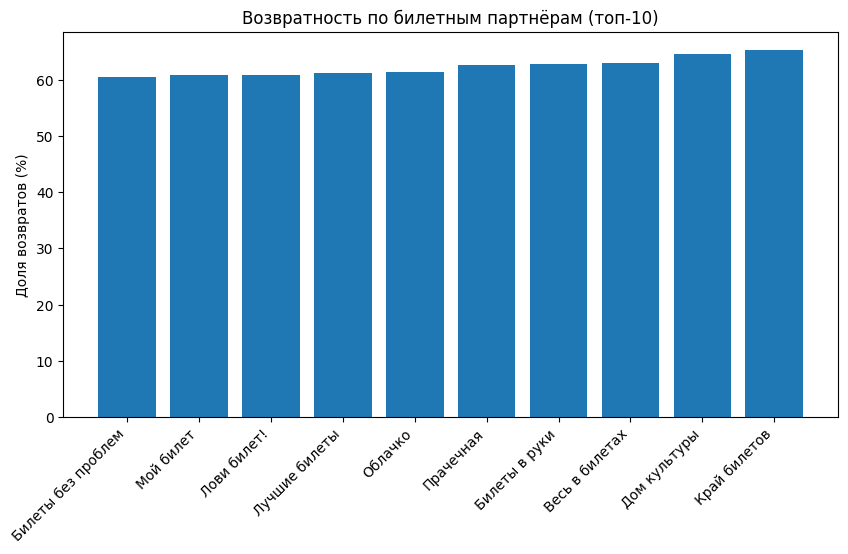

In [39]:
plot_return_rate(event_return, "Возвратность по жанру первого мероприятия")
plot_return_rate(device_return, "Возвратность по устройству первого заказа")
plot_return_rate(region_return_top10, "Возвратность по регионам (топ-10)")
plot_return_rate(service_return_top10, "Возвратность по билетным партнёрам (топ-10)")

**Вывод**

Средняя возвратность пользователей составляет 61.7%.

Пользователи, впервые пришедшие на театр и стендап, возвращаются чаще среднего, тогда как жанры «спорт», «выставки» и «ёлки» показывают более низкую возвратность. Мобильные пользователи также демонстрируют более высокий уровень возврата по сравнению с desktop.

По регионам и билетным операторам возвратность заметно различается, однако достоверные выводы можно делать только по крупным сегментам — показатели малых групп нестабильны.

**Итог:** наиболее успешные точки входа — отдельные жанры (театр, стендап) и мобильный канал; они формируют более лояльную аудиторию.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [40]:
#вычисляем возвратность в двух сегментах
sport_ret = event_return.loc["спорт", "returning_pct"]
concert_ret = event_return.loc["концерты", "returning_pct"]

sport_ret, concert_ret

(np.float64(55.8), np.float64(61.8))

Возвратность:

Спорт: 55.8%

Концерты: 61.8%

**Вывод по Гипотеза 1:**

Гипотеза не подтверждается.
Пользователи, начавшие с концертов, возвращаются значимо чаще, чем пользователи, впервые посетившие спортивные мероприятия.

In [41]:
#строим связь между сегментом и возвратностью
region_analysis = region_return.copy()
region_analysis[['users', 'returning_pct']].corr()

,users,returning_pct
users,1.000000,0.120076
returning_pct,0.120076,1.000000


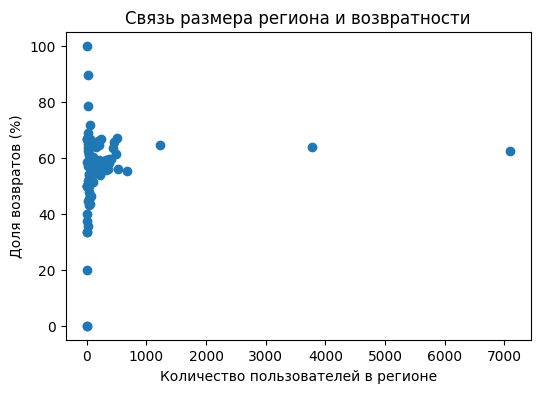

In [42]:
#визуализируем для удобства
plt.figure(figsize=(6, 4))
plt.scatter(region_analysis['users'], region_analysis['returning_pct'])
plt.xlabel("Количество пользователей в регионе")
plt.ylabel("Доля возвратов (%)")
plt.title("Связь размера региона и возвратности")
plt.show()

**Вывод по Гипотеза 2**

Гипотеза 2 не подтвердилась: корреляция между размером региона и возвратностью составляет лишь 0.12, что указывает на отсутствие значимой зависимости. Крупные регионы не демонстрируют более высокую возвратность.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [43]:
#разделим пользователей на 2 группы
one_order = user_profile_filtered[user_profile_filtered['is_two'] == 0]['avg_revenue_rub']
two_plus_orders = user_profile_filtered[user_profile_filtered['is_two'] == 1]['avg_revenue_rub']

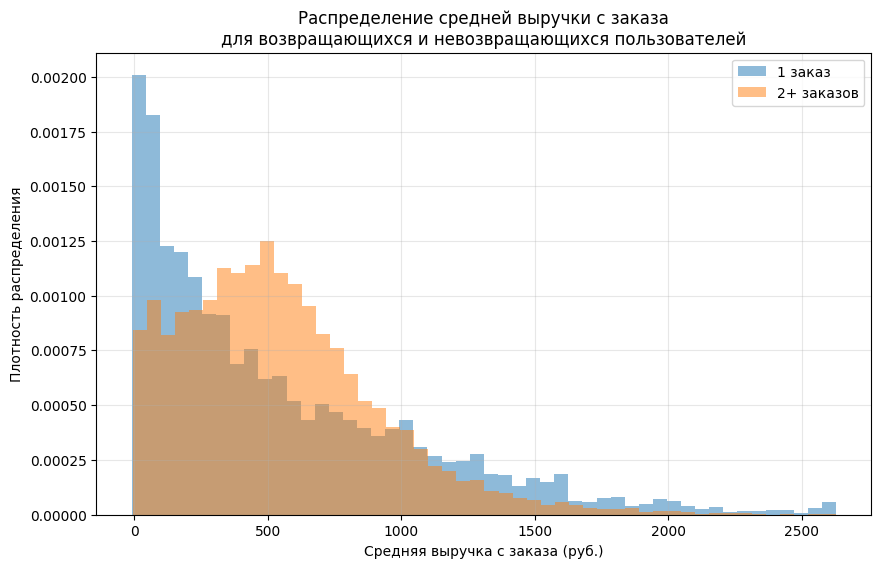

In [44]:
#построим сравнительные гистограммы
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

bins = 50  # одинаковые интервалы

plt.hist(one_order, bins=bins, alpha=0.5, density=True, label='1 заказ')
plt.hist(two_plus_orders, bins=bins, alpha=0.5, density=True, label='2+ заказов')

plt.xlabel("Средняя выручка с заказа (руб.)")
plt.ylabel("Плотность распределения")
plt.title("Распределение средней выручки с заказа\nдля возвращающихся и невозвращающихся пользователей")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Вывод**
Распределения средней выручки с заказа у возвращающихся и невозвращающихся пользователей заметно различаются.

1. Пользователи с одним заказом (синий)

Их средняя выручка концентрируется в диапазоне 0–300 руб. Это говорит о том, что такие пользователи чаще совершают заказы с низким чеком.

2. Пользователи, совершившие 2+ заказа (оранжевый)

Их распределение сдвинуто вправо: основной пик — примерно 300–700 руб. То есть они делают более дорогие и крупные заказы.

***Главное различие***

Возвращающиеся пользователи тратят больше в среднем, чем пользователи, которые сделали единственный заказ.

Пользователи с низким средним чеком гораздо реже возвращаются.

А пользователи с высоким средним чеком (600+ руб.) формируют основную часть лояльной аудитории.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [45]:
# разделим пользователей на две группы:
group_2_4 = user_profile_filtered[
    (user_profile_filtered['total_orders'] >= 2) &
    (user_profile_filtered['total_orders'] <= 4)
]['avg_revenue_rub']

group_5_plus = user_profile_filtered[
    user_profile_filtered['total_orders'] >= 5
]['avg_revenue_rub']

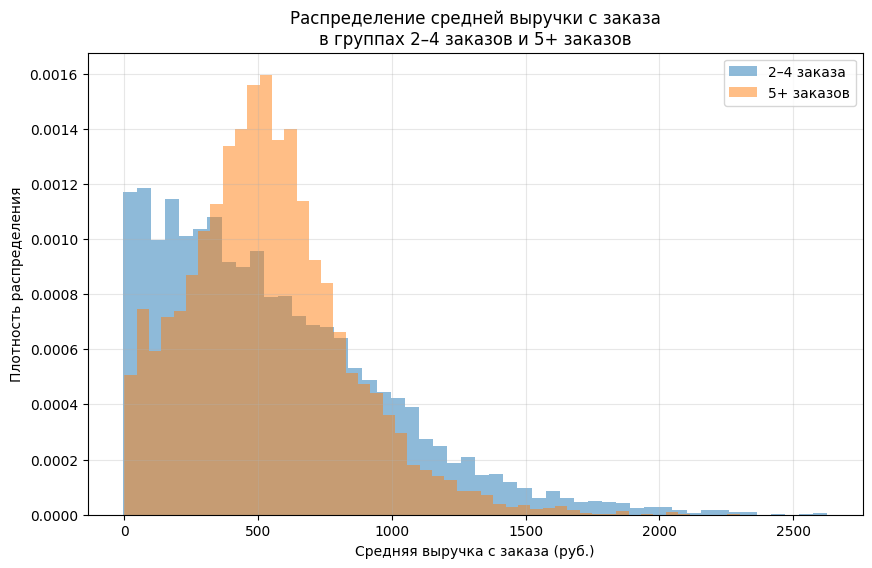

In [46]:
#построим сравнение распределений
plt.figure(figsize=(10, 6))

bins = 50

plt.hist(group_2_4, bins=bins, density=True, alpha=0.5, label='2–4 заказа')
plt.hist(group_5_plus, bins=bins, density=True, alpha=0.5, label='5+ заказов')

plt.xlabel("Средняя выручка с заказа (руб.)")
plt.ylabel("Плотность распределения")
plt.title("Распределение средней выручки с заказа\nв группах 2–4 заказов и 5+ заказов")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Вывод:** 

Да, различия есть.
Пользователи, совершающие 5 и более заказов, имеют более высокую среднюю выручку с заказа, чем пользователи, сделавшие 2–4 заказа.
Чем больше заказов пользователь делает, тем выше обычно его средний чек.

Это подтверждает гипотезу о том, что более активные пользователи более вовлечены и склонны тратить больше.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

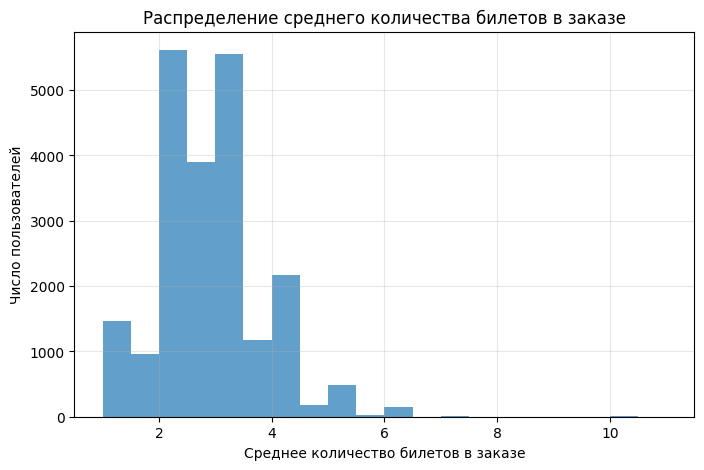

In [47]:
#построим гистограмму
plt.figure(figsize=(8,5))
plt.hist(user_profile_filtered['avg_tickets'], bins=20, alpha=0.7)
plt.xlabel("Среднее количество билетов в заказе")
plt.ylabel("Число пользователей")
plt.title("Распределение среднего количества билетов в заказе")
plt.grid(alpha=0.3)
plt.show()

In [48]:
#разделим пользователей на сегменты
user_profile_filtered = user_profile_filtered.copy()

def ticket_segment(x):
    if x < 2:
        return "1–2 билета"
    elif x < 3:
        return "2–3 билета"
    elif x < 5:
        return "3–5 билетов"
    else:
        return "5+ билетов"

user_profile_filtered["ticket_seg"] = user_profile_filtered["avg_tickets"].apply(ticket_segment)


In [49]:
#рассчитаем пользователей и возвратность по сегментам
ticket_stats = (
    user_profile_filtered
    .groupby("ticket_seg")
    .agg(
        users=("is_two", "count"),    # просто считаем строки
        returning=("is_two", "mean")  # доля вернувшихся
    )
    .reset_index()
)

ticket_stats["returning_pct"] = (ticket_stats["returning"] * 100).round(2)

ticket_stats


,ticket_seg,users,returning,returning_pct
0,1–2 билета,2419,0.513022,51.30
1,2–3 билета,9498,0.735839,73.58
2,3–5 билетов,9060,0.542605,54.26
3,5+ билетов,661,0.187595,18.76


**Вывод:**
    Пользователи распределены по сегментам **неравномерно**: большинство покупают в среднем 2–3 или 3–5 билетов, тогда как сегменты 1–2 и особенно 5+ билетов значительно меньше. Возвратность также различается: пользователи в сегменте 2–3 билета показывают аномально высокую долю повторных покупок, тогда как сегмент 5+ билетов характеризуется аномально низкой возвратностью, что связано с разовыми групповыми заказами.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [50]:
#определяем день недели первой покупки
user_profile_filtered["first_order_weekday"] = (
    user_profile_filtered["first_order_dt"].dt.day_name()
)

In [51]:
#собираем статистику по неделям
weekday_stats = (
    user_profile_filtered
    .groupby("first_order_weekday")
    .agg(
        users=("is_two", "count"),
        returning=("is_two", "mean")
    )
    .reset_index()
)

weekday_stats["returning_pct"] = (weekday_stats["returning"] * 100).round(2)
weekday_stats

,first_order_weekday,users,returning,returning_pct
0,Friday,3259,0.598343,59.83
1,Monday,2930,0.630375,63.04
2,Saturday,3326,0.628082,62.81
3,Sunday,2777,0.600288,60.03
4,Thursday,3113,0.594282,59.43
5,Tuesday,3176,0.619018,61.90
6,Wednesday,3057,0.621851,62.19


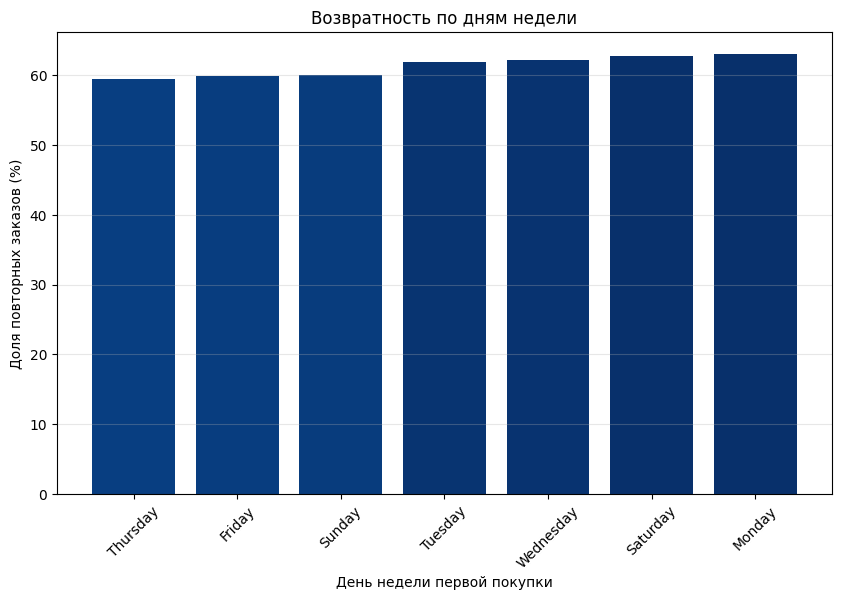

In [52]:
#визуализируем
weekday_stats_sorted = weekday_stats.sort_values("returning_pct")

plt.figure(figsize=(10, 6))
bars = plt.bar(
    weekday_stats_sorted["first_order_weekday"],
    weekday_stats_sorted["returning_pct"],
    color=plt.cm.Blues(weekday_stats_sorted["returning_pct"] / weekday_stats_sorted["returning_pct"].max())
)

plt.ylabel("Доля повторных заказов (%)")
plt.xlabel("День недели первой покупки")
plt.title("Возвратность по дням недели")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.show()

**Вывод:**


 Распределение пользователей по дням недели первой покупки и их возвратность демонстрируют умеренные различия. В большинстве дней недели показатели возвратности находятся примерно на одном уровне, отклоняясь от среднего значения незначительно.

В некоторых днях может наблюдаться чуть более высокая доля повторных заказов, но различия не носят выраженного характера. Это указывает на то, что **день недели первой покупки не является существенным фактором**, влияющим на вероятность возврата клиента.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [53]:
#разделим пользователей на 2 группы
group_2_4 = user_profile_filtered[
    (user_profile_filtered["total_orders"] >= 2) &
    (user_profile_filtered["total_orders"] <= 4)
]["avg_days_between_orders"].dropna()

group_5_plus = user_profile_filtered[
    user_profile_filtered["total_orders"] >= 5
]["avg_days_between_orders"].dropna()

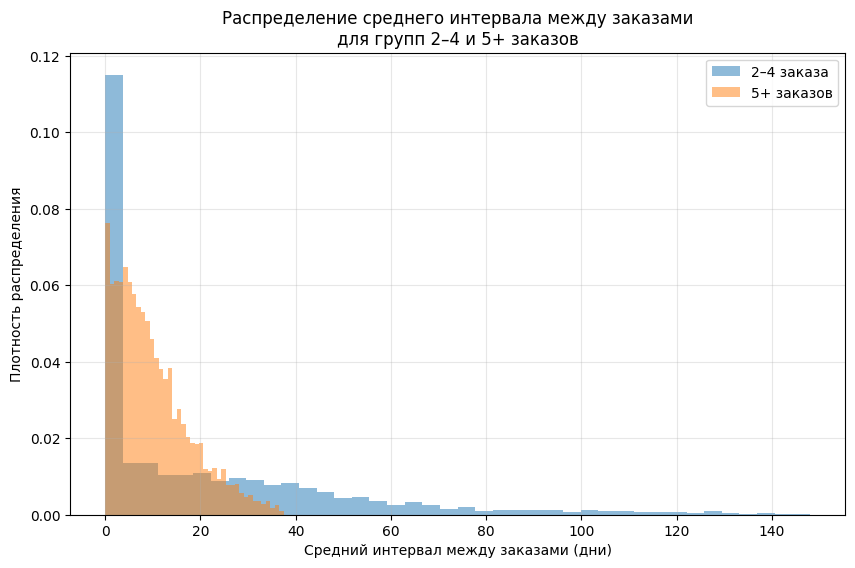

In [54]:
#построим сравнение распределений
plt.figure(figsize=(10,6))

bins = 40

plt.hist(group_2_4, bins=bins, density=True, alpha=0.5, label="2–4 заказа")
plt.hist(group_5_plus, bins=bins, density=True, alpha=0.5, label="5+ заказов")

plt.xlabel("Средний интервал между заказами (дни)")
plt.ylabel("Плотность распределения")
plt.title("Распределение среднего интервала между заказами\nдля групп 2–4 и 5+ заказов")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [55]:
#посчитаем основные статистики
print("Средний интервал 2–4 заказа:", group_2_4.mean())
print("Медиана 2–4:", group_2_4.median())

print("Средний интервал 5+ заказов:", group_5_plus.mean())
print("Медиана 5+:", group_5_plus.median())

Средний интервал 2–4 заказа: 21.329939
Медиана 2–4: 9.0
Средний интервал 5+ заказов: 9.900063
Медиана 5+: 8.117647171020508


**Вывод:**
    Пользователи, совершающие 5 и более заказов, покупают значительно чаще: их средний интервал между заказами составляет около 10 дней, тогда как у пользователей с 2–4 заказами — более 21 дня. Распределение также показывает, что активные пользователи гораздо реже делают длинные паузы. Это подтверждает, что короткие интервалы между покупками являются признаком высокой вовлечённости и устойчивого удержания.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [56]:
!pip install phik

In [57]:
from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [58]:
#рассчитаем phi_k для всего датасета

interval_cols = [
    "avg_revenue_rub",
    "avg_tickets",
    "avg_days_between_orders",
    "total_orders"
]

phik_matrix_full = user_profile_filtered.phik_matrix(interval_cols=interval_cols)

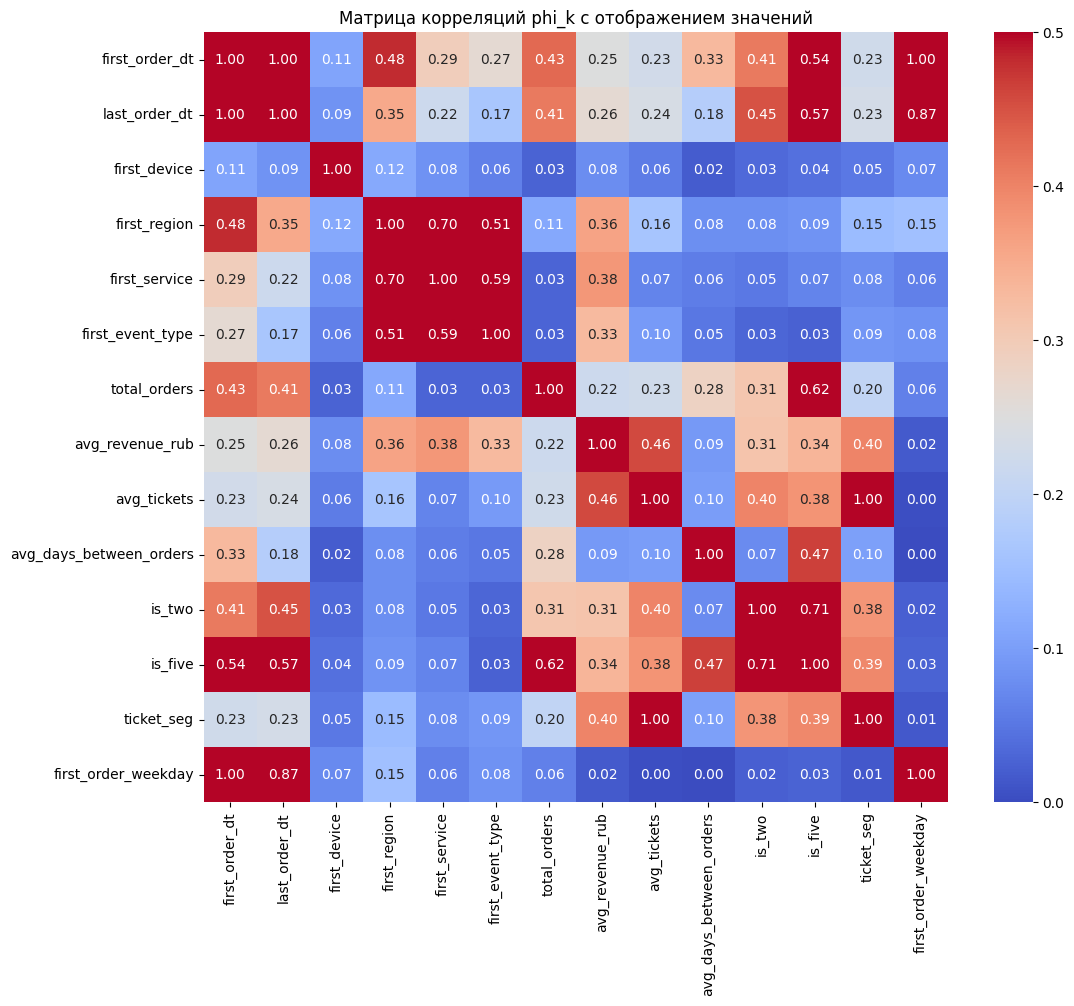

In [59]:
#визуализируем
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(
    phik_matrix_full,
    cmap="coolwarm",
    annot=True,      # включаем подписи
    fmt=".2f",        # формат чисел (2 знака после запятой)
    vmin=0,
    vmax=0.5
)
plt.title("Матрица корреляций phi_k с отображением значений")
plt.show()

**Вывод:**
    Количество заказов связано прежде всего c поведенческими характеристиками пользователя, а не с параметрами его первого заказа. Наиболее сильные связи показывают:

avg_days_between_orders (0.28) — чем короче интервалы между покупками, тем выше общее число заказов;

avg_tickets (0.23) — пользователи, покупающие больше билетов, как правило, более лояльны;

avg_revenue_rub (0.22) — высокий средний чек связан с большей активностью.

Категориальные признаки первого заказа (жанр, устройство, регион, билетный оператор) практически не влияют на количество заказов и имеют слабую корреляцию.

**Итог:** ключевыми предикторами количества заказов являются частота покупок, размер заказа и стоимость заказа — то есть поведенческие, а не первичные признаки пользователя.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Информация о данных**

В анализе использовались данные заказов Яндекс Афиши за 2024 год: исходно 290 611 заказов, после фильтрации выбросов по выручке объём сократился примерно на 0,97%. Заказы в тенге (KZT) были приведены к рублям по ежедневному курсу из отдельного датасета, для чего были добавлены технические столбцы order_date, nominal, curs, cdx и рассчитан ключевой показатель revenue_rub. Из revenue_rub были удалены отрицательные значения и значения выше 99-го перцентиля (2628 ₽), а из пользовательского профиля — аномальные наблюдения с total_orders выше 99-го перцентиля (152 заказа), что затронуло около 0,99% пользователей. В результате сформирован итоговый профиль примерно из 21,6 тыс. пользователей с агрегированными признаками по заказам и поведению.

**Основные результаты анализа.**

***Аудитория и активность***

В анализе участвуют ~21,6 тыс. пользователей.
Медианное число заказов — 2; 61,7% вернулись хотя бы один раз; 29% сделали 5+ заказов.
Большинство — пользователи с 1–4 заказами, доля «суперактивных» невелика.

***Первый заказ и возвратность***

Основные точки входа:
— концерты (≈44%), театр и категория «другое»;
— mobile (≈83%);
— несколько крупных регионов;
— 4–5 ключевых билетных партнёров.

Различия по возвратности между жанрами, устройствами, регионами и партнёрами умеренные.
Гипотезы не подтвердились:

спорт не возвратнее концертов;

крупные регионы не показывают большей лояльности.

***Чек, билеты и повторные покупки***

Один заказ → низкий средний чек (0–300 ₽).
Вернувшиеся пользователи имеют более высокую среднюю выручку; у группы 5+ заказов чек выше, чем у 2–4 заказов.

По числу билетов:

самые возвратные — пользователи с 2–3 билетами (≈74%);

5+ билетов — редкий сегмент с минимальной возвратностью (≈19%), вероятно разовые групповые покупки.

***Время и удержание***

День недели первого заказа почти не влияет (возвратность 59–63%).
Но интервал между заказами — важный показатель:

у 2–4 заказов ≈21 день,

у 5+ заказов ≈10 дней.
Чем чаще пользователь покупает, тем выше его удержание.

***Корреляции***

С total_orders сильнее всего связаны поведенческие признаки:

avg_days_between_orders (≈0.28),

avg_tickets (≈0.23),

avg_revenue_rub (≈0.22).

Категориальные признаки первого заказа дают слабую связь и почти не влияют на будущую активность.

# Рекомендации заказчику


`Сделать ставку на поведенческие метрики в модели прогнозирования и маркетинге`

 - Использовать средний чек, среднее число билетов и средний интервал между покупками как ключевые предикторы лояльности.

 - Выделять пользователей с растущим чеком и 2–3 билетами в заказе — это ядро лояльной аудитории.

`Работа с частотой покупок (удержание)`

 - Настроить триггерные коммуникации (email, push, ремаркетинг), если пользователь не покупал дольше типичного интервала (например, >20–25 дней).

 - Предлагать персональные промокоды/подборки мероприятий, чтобы сокращать паузы между заказами.

`Сегменты по составу заказа`

 - Сегмент 2–3 билета — наиболее перспективный: высокий уровень возвратов и значительный размер. Стоит инвестировать в персональные предложения и программы лояльности.

 - Сегмент 5+ билетов — низкая возвратность; это кандидаты на отдельные активности: спецпредложения для корпоративов, групповые акции, напоминания перед повторением «сезонных» событий.

`Усиление успешных точек входа`

 - Концерты и театр — хорошие входные жанры: с них приходит много пользователей, и они демонстрируют хорошую возвратность.

 - Имеет смысл усиливать промо по этим категориям (главная страница, подборки, персональные рекомендации), особенно для новых пользователей.

`Фокус на мобильный канал`

 - Так как ≈83% первых заказов приходится на mobile, мобильное приложение и мобильная версия сайта должны оставаться основным приоритетом: удобный поиск, быстрый checkout, сохранённые карты/кошельки.

`Партнёрства и региональное развитие`

 - Основной поток пользователей обеспечивают несколько крупных операторов и несколько регионов. Для них стоит:

   - развивать совместные акции и кросс-промо;

   - использовать их как плацдарм для тестирования новых механизмов удержания.

 - Для «длинного хвоста» партнёров ROI маркетинга нужно оценивать аккуратнее из-за малых выборок.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**